# Deconvolve escape scores to fraction escape for individual mutations and homologs
This Python Jupyter notebook estimates the escape fraction for individual mutations from the variant measurements.
It does this in two ways: it uses [global epistasis models](https://www.pnas.org/content/115/32/E7550) to deconvolve the effects of individual mutations from the escape scores (many of which are for multiply mutated variants) and it directly gets estimates from just singly mutated variants.
It then outputs estimates of the escape-fraction for each mutation and summary site-level metrics.

The global epistasis models are those implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html).

The notebook also estimates the escape fractions for the homologs by averaging over the relevant variants.

## Set up analysis

This notebook primarily makes use of the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package, and uses [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting syntax:

In [1]:
import collections
import itertools
import math
import multiprocessing
import os
import pickle
import time
import warnings

import Bio.SeqIO

import dms_variants.binarymap
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.globalepistasis
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray-grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.8.4


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [6]:
os.makedirs(config['escape_scores_dir'], exist_ok=True)

## Read escape scores
Read the escape scores.

For the primary target, retain only the ones that passed the pre-count and ACE2-binding / expression filters and do **not** have stop codons.
For the homologs, we apply the pre-count filter, but not the binding/ expression ones because the homologs to retain are specified manually in the configuration:

In [7]:
primary_target = Bio.SeqIO.read(config['wildtype_sequence'], format='fasta').name
print(f"Reading escape scores for primary target {primary_target} from {config['escape_scores']}")
escape_scores_primary = (
    pd.read_csv(config['escape_scores'])
    .fillna('')  # empty substitution strings mean no subs, not NA
    .query('pass_pre_count_filter == True')
    .query('pass_ACE2bind_expr_filter == True')
    .query('not aa_substitutions.str.contains("\*")', engine='python')
    )
assert all(escape_scores_primary['target'] == primary_target)
print(f"Read {len(escape_scores_primary)} scores for the primary target.")

print(f"\nReading escape scores for homologs from {config['escape_scores_homologs']}")
homologs_to_keep = config['homologs_to_keep']
print(f"For homologs, just keeping the following: {', '.join(homologs_to_keep)}")
escape_scores_homologs = (pd.read_csv(config['escape_scores_homologs'])
                          .query('pass_pre_count_filter == True')
                          .query('target in @homologs_to_keep')
                          )
print(f"Read {len(escape_scores_homologs)} scores for the homologs.")

Reading escape scores for primary target SARS-CoV-2 from results/escape_scores/scores.csv
Read 180869 scores for the primary target.

Reading escape scores for homologs from results/escape_scores/scores_homologs.csv
For homologs, just keeping the following: SARS-CoV-2, SARS-CoV, GD-Pangolin, LYRa11, RaTG13, WIV16
Read 48 scores for the homologs.


## Fit global epistasis models
Many of our mutants of the primary target have multiple mutations, and we'd like a model to estimate the effects of individual mutations.
We get these estimates by fitting global epistasis models to each selection and library for the mutants of the primary target.
We fit both a global epistasis model and a no-epistasis (linear) model.
For now we use just a Gaussian likelihood function, which seems to work better than a Cauchy likelihood.
Because the fitting takes a while, we do it in a multiprocessing queue.

Note also that we filter variants based on how many other variants have the substitutions that they contain, potentially removing variants with substitutions seen only in one or a few variants:

Removing variants with substitutions not seen in >=0 single-substitution variants and >=2 variants total.
Fitting 16 models using 16 CPUs...
1 of 16: Fit lib2, 2B04_400, no_epistasis in 0.1 sec.
2 of 16: Fit lib1, 2C02_400, no_epistasis in 0.2 sec.
3 of 16: Fit lib1, 2B04_400, no_epistasis in 0.2 sec.
4 of 16: Fit lib1, mAb-2E06_400, no_epistasis in 0.1 sec.
5 of 16: Fit lib2, mAb-2E06_400, no_epistasis in 0.1 sec.
6 of 16: Fit lib2, 2C02_400, no_epistasis in 0.3 sec.
7 of 16: Fit lib2, 2C03_400, no_epistasis in 0.4 sec.
8 of 16: Fit lib1, 2C03_400, no_epistasis in 0.4 sec.
9 of 16: Fit lib1, 2C02_400, global_epistasis in 0.7 sec.
10 of 16: Fit lib2, 2B04_400, global_epistasis in 0.9 sec.
11 of 16: Fit lib2, mAb-2E06_400, global_epistasis in 2.5 sec.
12 of 16: Fit lib1, mAb-2E06_400, global_epistasis in 3.5 sec.
13 of 16: Fit lib2, 2C02_400, global_epistasis in 6.0 sec.
14 of 16: Fit lib1, 2B04_400, global_epistasis in 15.6 sec.
15 of 16: Fit lib1, 2C03_400, global_epistasis in 24.5 se

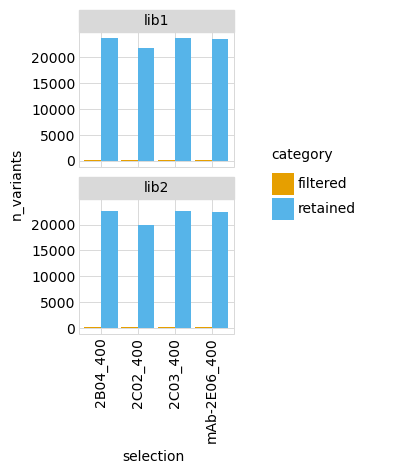

In [8]:
min_single_counts = config['global_epistasis_filter_by_subs_observed_single']
min_any_counts = config['global_epistasis_filter_by_subs_observed_any']
print(f"Removing variants with substitutions not seen in >={min_single_counts} "
      f"single-substitution variants and >={min_any_counts} variants total.")

# create a list of models to fit, filtering variants based on criteria above
to_fit = []
n_filtered_variants = {'selection': [],
                       'library': [],
                       'retained': [],
                       'filtered': []}
for (name, library), df in escape_scores_primary.groupby(['name', 'library']):
    filtered_df = dms_variants.codonvarianttable.filter_by_subs_observed(
                                    df,
                                    min_single_counts,
                                    min_any_counts)
    n_filtered_variants['selection'].append(name)
    n_filtered_variants['library'].append(library)
    n_filtered_variants['retained'].append(len(filtered_df))
    n_filtered_variants['filtered'].append(len(df) - len(filtered_df))
    binarymap = dms_variants.binarymap.BinaryMap(filtered_df,
                                                 func_score_col='score',
                                                 func_score_var_col='score_var')
    for epistasis_func, Model in [
            ('global_epistasis', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no_epistasis', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ]:
        key = (library, name, epistasis_func)
        to_fit.append((key, Model(binarymap)))

# plot how many variants filtered / retained
n_filtered_variants = (
    pd.DataFrame(n_filtered_variants)
    .melt(id_vars=['selection', 'library'],
          value_name='n_variants',
          var_name='category')
    )
p = (ggplot(n_filtered_variants) +
     aes('selection', 'n_variants', fill='category') +
     geom_bar(stat='identity', position=position_dodge()) +
     facet_wrap('~ library', ncol=1) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * n_filtered_variants['selection'].nunique(),
                        2 * n_filtered_variants['library'].nunique()),
           ) +
     scale_fill_manual(values=CBPALETTE[1:])
     )
_ = p.draw()

# fit the models in a multiprocessing queue
ncpus = min(config['max_cpus'], multiprocessing.cpu_count())
print(f"Fitting {len(to_fit)} models using {ncpus} CPUs...")

def fit_func(key_model_tup):
    key, model = key_model_tup
    start = time.time()
    try:
        model.fit()
    except dms_variants.globalepistasis.EpistasisFittingError:
        model = None  # none for model if error fitting
    return key, model, time.time() - start

models = {}
fit_failed = []
with multiprocessing.Pool(ncpus) as pool:
    for i, (key, model, time_sec) in enumerate(pool.imap_unordered(fit_func, to_fit)):
        desc = ', '.join(key)
        if model is None:
            print(f"{i + 1} of {len(to_fit)}: Fit FAILED for {desc} in {time_sec:.1f} sec.")
            fit_failed.append(desc)
        else:
            print(f"{i + 1} of {len(to_fit)}: Fit {desc} in {time_sec:.1f} sec.")
            models[key] = model

models_pickle_file = os.path.join(config['escape_scores_dir'], 'epistasis_models.pickle')
print(f"Dumping the model fits to {models_pickle_file}")
with open(models_pickle_file, 'wb') as f:
    pickle.dump(models, f)

Now we compare the epistasis models fit by AIC.
Specifically, we can compare model fits for the same selection.
In principle, if the global epistasis models are better than the no-epistasis (linear) models, then they should have a better (lower) AIC than the linear model.
We compute the $\Delta$AIC as the no-epistasis (linear) model AIC minus the global epistasis model AIC.
This $\Delta$AIC should be > 0, and if it's not that indicates that the global epistasis model should be treated with caution:

These are the samples for which the global_epistasis AIC is greater than the no_epistasis AIC. 
There is probably something wrong with them:



epistasis_func,selection,library,global_epistasis,no_epistasis,deltaAIC
,2B04_400,lib2,-85668.110986,-86793.233233,-1125.122247


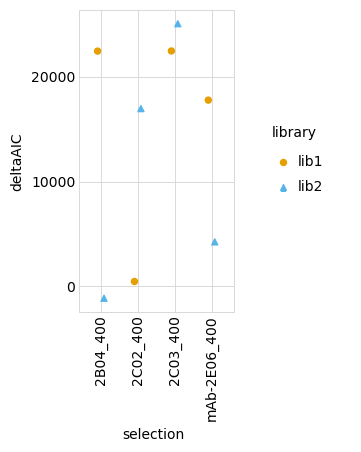

In [9]:
if fit_failed:
    print('Note that the fit FAILED for the following:\n' + '\n'.join(fit_failed))

loglik_df = (
    pd.DataFrame.from_records(
        [(name, lib, epistasis_func, model.loglik, model.nparams)
         for (lib, name, epistasis_func), model in models.items()],
        columns=['selection', 'library', 'epistasis_func', 'log_likelihood', 'nparams']
        )
    .assign(AIC=lambda x: 2 * x['nparams'] - 2 * x['log_likelihood'])
    .pivot_table(index=['selection', 'library'],
                 columns='epistasis_func',
                 values='AIC',
                 aggfunc='first',  # https://stackoverflow.com/a/39229232
                 )
    .assign(deltaAIC=lambda x: x['no_epistasis'] - x['global_epistasis'])
    .reset_index()
    )

if len(loglik_df.query('deltaAIC < 0')) > 0:
    print("These are the samples for which the global_epistasis AIC is greater than the no_epistasis AIC.", 
          "\nThere is probably something wrong with them:\n")
    display(HTML(loglik_df.query('deltaAIC < 0').to_html(index=False)))

p = (ggplot(loglik_df) +
     aes('selection', 'deltaAIC', color='library', shape='library') +
     geom_point(size=2, position=position_dodge(width=0.35)) +
     scale_color_manual(values=CBPALETTE[1:]) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * loglik_df['selection'].nunique(), 2 * loglik_df['library'].nunique()),
           )
     )

_ = p.draw()

Now plot the "shape" of global epistasis as the latent phenotype of each variant versus the experimentally measured phenotype:

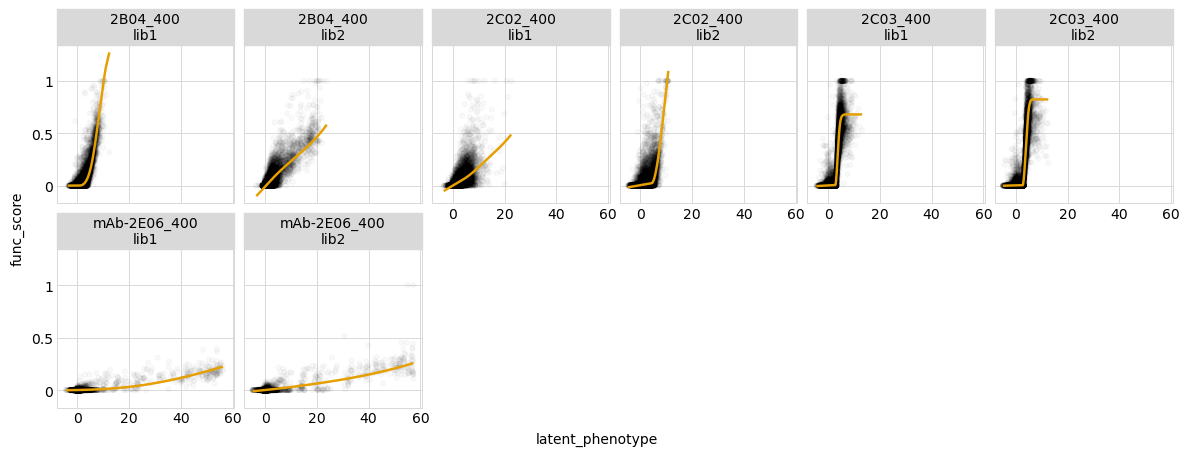

In [10]:
epistasis_shape_df = []
for (lib, selection, epistasis_func), model in models.items():
    if epistasis_func != 'global_epistasis':
        continue
    epistasis_shape_df.append(
            model.phenotypes_df.assign(selection=selection,
                                       library=lib)
            )
epistasis_shape_df = pd.concat(epistasis_shape_df, sort=False, ignore_index=True)

nfacets = len(epistasis_shape_df.groupby(['selection', 'library']))
ncol = min(6, nfacets)
nrow = math.ceil(nfacets / ncol)
xlim_quantile = 0.0005  # extend x-axis limits to these quintiles of data, cut points beyond
p = (ggplot(epistasis_shape_df) +
     aes('latent_phenotype', 'func_score') +
     geom_point(alpha=0.025) +
     geom_line(mapping=aes(y='observed_phenotype'), color=CBPALETTE[1], size=1) +
     facet_wrap('~ selection + library', ncol=ncol) +
     theme(figure_size=(2.4 * ncol, 2.4 * nrow)) +
     scale_x_continuous(limits=epistasis_shape_df
                               ['latent_phenotype']
                               .quantile([xlim_quantile, 1 - xlim_quantile]),
                        )
     )

_ = p.draw()

## Effects of mutations from epistasis models and direct measurements
We now examine the effects of mutations. 
We can get those effects in two ways: the escape scores measured directly for just the single-mutant variants (averaged across those variants if we have not already grouped by amino acid substitution), or the observed phenotypes (predicted scores) of the single mutants predicted by the global epistasis models.
These global epistasis observed phenotypes differ from the single-mutant raw average scores above in that they take advantage of information in the multiple mutants as deconvolved by the global epistasis models, and so in principle should be superior.

First, we get a data frame that has all of these measurements for each selection and library, also indicating how many measurements we have of single-mutant variants and multiple-mutant variants for each mutation and filtering mutations with not enough of these measurements:

Removing mutations that do not have EITHER >= 1 single-mutant measurements or >= 2 any-mutant measurements.


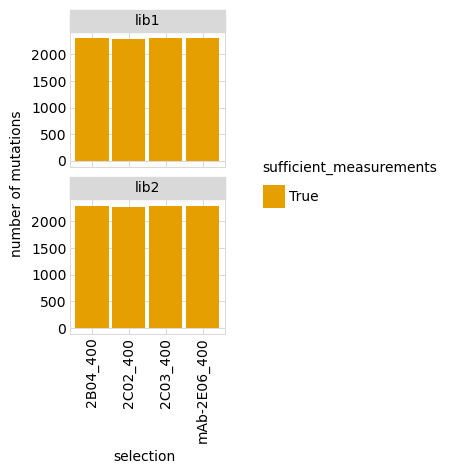

In [11]:
# observed phenotypes of single mutants from global epistasis models
effects_df = pd.DataFrame({})
for (lib, selection, epistasis_func), model in models.items():
    if epistasis_func != 'global_epistasis':
        continue  # only get global epistasis values
    # We want to determine how many times each mutation was measured as a single mutant
    # and in any context, so we make counters that give counts of each variant and
    # each mutation in context of any variant:
    variant_counter = collections.Counter(model.binarymap.substitution_variants)
    muts_counter = collections.Counter(itertools.chain.from_iterable(
                        s.split() for s in model.binarymap.substitution_variants))
    effects_df = effects_df.append(
        pd.DataFrame({'selection': selection,
                      'library': lib,
                      'mutation': model.binarymap.all_subs})
        .assign(n_single_mut_measurements=lambda x: x['mutation'].map(variant_counter),
                n_any_mut_measurements=lambda x: x['mutation'].map(muts_counter),
                )
        .pipe(model.add_phenotypes_to_df, substitutions_col='mutation')
        .drop(columns='latent_phenotype')
        .rename(columns={'observed_phenotype': 'epistasis_model_score'}),
        ignore_index=True, sort=False,
        )
    
# only retain mutations that have sufficient variants in either a single or multi-mutant context
print(f"Removing mutations that do not have EITHER >= {config['escape_frac_min_single_mut_measurements']} "
      f"single-mutant measurements or >= {config['escape_frac_min_any_mut_measurements']} any-mutant "
      'measurements.')
effects_df = (
    effects_df
    .assign(sufficient_measurements=lambda x: (
                (x['n_single_mut_measurements'] >= config['escape_frac_min_single_mut_measurements']) |
                (x['n_any_mut_measurements'] >= config['escape_frac_min_any_mut_measurements']))
            )
    )
# plot how many mutations have insufficient measurements
p = (ggplot(effects_df) +
     aes('selection', fill='sufficient_measurements') +
     geom_bar(position=position_dodge()) +
     facet_wrap('~ library', ncol=1) +
     scale_fill_manual(values=CBPALETTE[1: ]) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * effects_df['selection'].nunique(), 2 * effects_df['library'].nunique())
           ) +
     ylab('number of mutations')
     )
_ = p.draw()
# remove mutations with insufficient measurements
effects_df = (effects_df
              .query('sufficient_measurements == True')
              .drop(columns='sufficient_measurements')
              )

# get raw average single-mutant scores
raw_avg_single_mut_scores = (
    escape_scores_primary
    .query('n_aa_substitutions == 1')
    .rename(columns={'name': 'selection',
                     'aa_substitutions': 'mutation'})
    .groupby(['selection', 'library', 'mutation'])
    .aggregate(raw_single_mut_score=pd.NamedAgg('score', 'mean'))
    .reset_index()
    )
    
# add single-mutant raw average scores to data frame with global epistasis observed phenotypes
effects_df = (
    effects_df
    .merge(raw_avg_single_mut_scores,
           how='outer',
           validate='one_to_one',
           )
    )

# some error checks
assert len(effects_df) == len(effects_df.drop_duplicates()), 'duplicate rows in `effects_df`'
assert all(effects_df['raw_single_mut_score'].notnull() | (effects_df['n_single_mut_measurements'] == 0))

We need to compute the escape scores (calculated as [here](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html?highlight=escape_scores#dms_variants.codonvarianttable.CodonVariantTable.escape_scores)) back to escape fractions.
We define a function to do this depending on the score type:

In [12]:
def score_to_frac(score):
    """Convert escape score to escape fraction."""
    floor = config['escape_score_floor_E']
    ceil = config['escape_score_ceil_E']
    if config['escape_score_type'] == 'frac_escape':
        return min(ceil, max(floor, score))  # just the score after applying ceiling and floor
    elif config['escape_score_type'] == 'log_escape':
        # convert score back to fraction, apply ceiling, then re-scale so floor is 0
        frac = 2**score
        frac = min(ceil, max(floor, frac))
        frac = (frac - floor) / (ceil - floor)
        return frac
    else:
        raise ValueError(f"invalid `escape_score_type` of {config['escape_score_type']}")

effects_df = (
    effects_df
    .assign(mut_escape_frac_epistasis_model=lambda x: x['epistasis_model_score'].map(score_to_frac),
            mut_escape_frac_single_mut=lambda x: x['raw_single_mut_score'].map(score_to_frac),
            )
    )

Add rows that are the **average** of the two libraries for the fraction escape for all mutations that are present in both libraries (and if in just one library, the value in that), the number of libraries each mutation is measured in, and the sum of the statistics giving the number of measurements:

In [13]:
nlibs = effects_df.query('library != "average"')['library'].nunique()

effects_df = (
    effects_df
    .query('library != "average"')  # git rid of averages if already there
    .assign(nlibs=1)
    .append(effects_df
            .query('library != "average"')
            .groupby(['selection', 'mutation'])
            .aggregate(nlibs=pd.NamedAgg('library', 'count'),
                       mut_escape_frac_epistasis_model=pd.NamedAgg('mut_escape_frac_epistasis_model', 'mean'),
                       mut_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut', 'mean'),
                       n_any_mut_measurements=pd.NamedAgg('n_any_mut_measurements', 'sum'),
                       n_single_mut_measurements=pd.NamedAgg('n_single_mut_measurements', 'sum'),
                       )
            .assign(library="average")
            .reset_index(),
            ignore_index=True, sort=False,
            )
    )

Plot the correlations of the escape fractions among the two libraries for all selections performed on both libraries.
Plot correlations for the escape fractions calculated from the raw single-mutant scores, and those from the epistasis models for just mutations present in single-mutant variants (most comparable to the raw single-mutant scores, since the same variants) and for all variants:

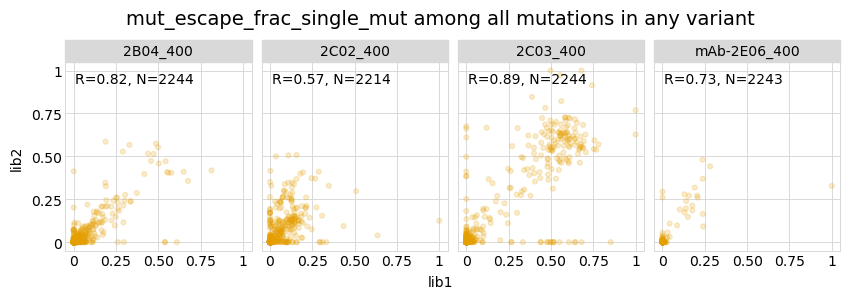

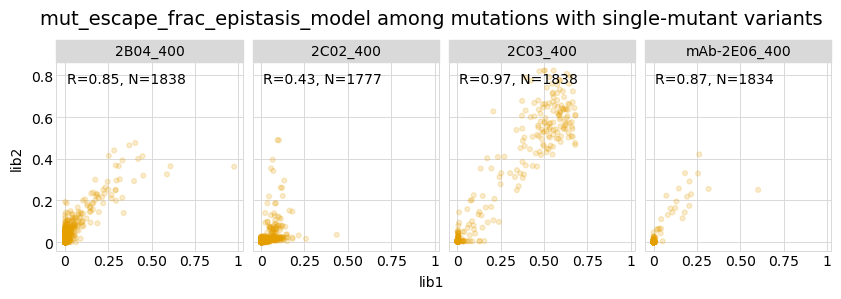

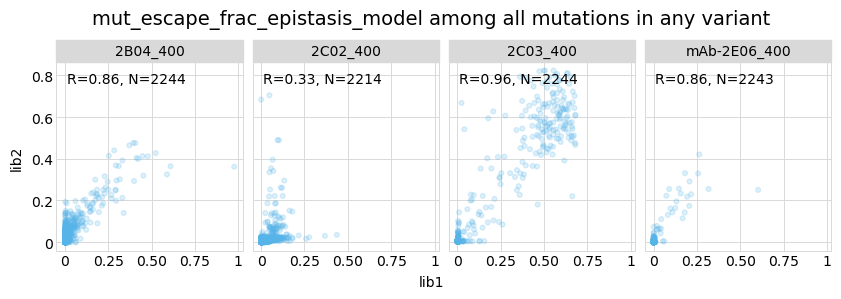

In [14]:
libraries = [lib for lib in effects_df['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for val, has_single_mut_measurement, color in [
        ('mut_escape_frac_single_mut', False, CBPALETTE[1]),
        ('mut_escape_frac_epistasis_model', True, CBPALETTE[1]),
        ('mut_escape_frac_epistasis_model', False, CBPALETTE[2]),
        ]:
    # wide data frame with each library's score in a different column
    effects_df_wide = (
        effects_df
        .query('library != "average"')
        .query(f"n_single_mut_measurements >= {int(has_single_mut_measurement)}")
        # just get selections with 2 libraries
        .assign(nlibs=lambda x: x.groupby('selection')['library'].transform('nunique'))
        .query('nlibs == 2')
        # now make columns for each library, only keep mutants with scores for both libs
        .pivot_table(index=['selection', 'mutation'],
                     columns='library',
                     values=val)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        effects_df_wide
        .groupby('selection')
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['selection', 'correlation']]
        # add number of mutations measured
        .merge(effects_df_wide
               .groupby('selection')
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    nfacets = effects_df_wide['selection'].nunique()
    ncol = min(nfacets, 5)
    nrow = math.ceil(nfacets / ncol)
    xmin = effects_df_wide[libraries[0]].min()
    xspan = effects_df_wide[libraries[0]].max() - xmin
    ymin = effects_df_wide[libraries[1]].min()
    yspan = effects_df_wide[libraries[1]].max() - ymin
    p = (ggplot(effects_df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(alpha=0.2, color=color) +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_wrap('~ selection', ncol=ncol) +
         theme(figure_size=(2.5 * ncol, 2.5 * nrow),
               plot_title=element_text(size=14)) +
         ggtitle(val + 
                 (' among mutations with single-mutant variants' if has_single_mut_measurement
                  else ' among all mutations in any variant')
                 )
         )

    _ = p.draw()

## Escape at the site level
The above analysis estimates the effects of mutations.
We also compute escape statistics at the **site** level.
First, add sites to the data frame of mutational effects:

In [15]:
effects_df = (
    effects_df
    .assign(site=lambda x: x['mutation'].str[1: -1].astype(int),
            wildtype=lambda x: x['mutation'].str[0],
            mutant=lambda x: x['mutation'].str[-1],
            )
    )

Now compute some site-level metrics.
These are the average and total escape fraction at each site over all mutations at the site:

In [16]:
site_effects_df = (
    effects_df
    .groupby(['selection', 'library', 'site'])
    .aggregate(
        site_avg_escape_frac_epistasis_model=pd.NamedAgg('mut_escape_frac_epistasis_model', 'mean'),
        site_total_escape_frac_epistasis_model=pd.NamedAgg('mut_escape_frac_epistasis_model', 'sum'),
        site_avg_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut', 'mean'),
        site_total_escape_frac_single_mut=pd.NamedAgg('mut_escape_frac_single_mut', 'sum'),
        )
    .reset_index()
    )

display(HTML(site_effects_df.head().to_html(index=False)))

selection,library,site,site_avg_escape_frac_epistasis_model,site_total_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,site_total_escape_frac_single_mut
2B04_400,average,1,0.002771,0.052650,0.003428,0.065128
2B04_400,average,2,0.002571,0.048857,0.002035,0.038670
2B04_400,average,3,0.002407,0.045740,0.003272,0.062175
2B04_400,average,4,0.007498,0.142454,0.004559,0.086620
2B04_400,average,5,0.002667,0.050677,0.001858,0.035294


Plot correlations between libraries of the same selection for the site-level statistics:

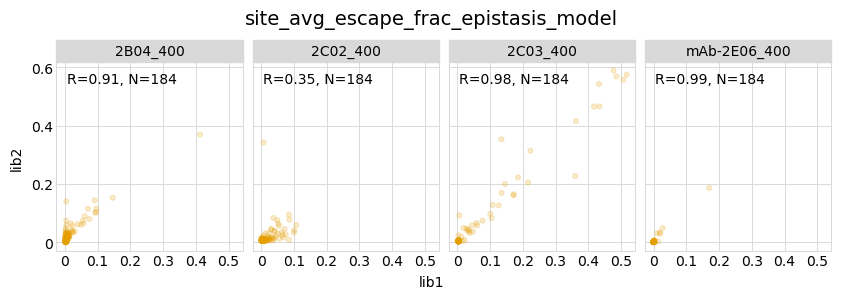

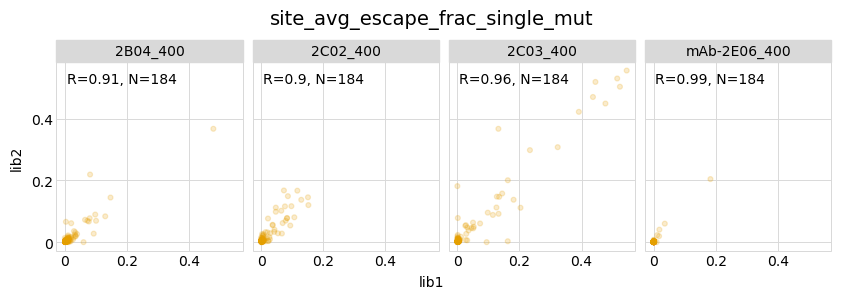

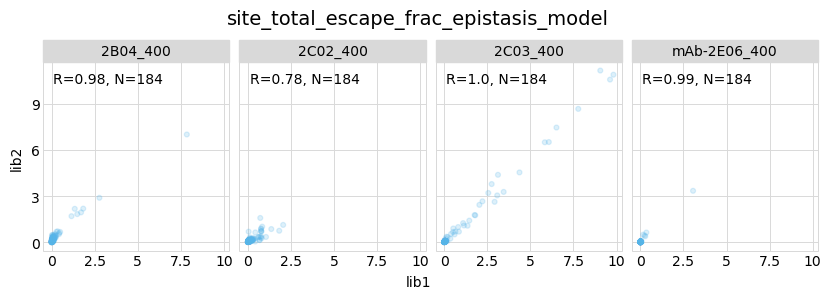

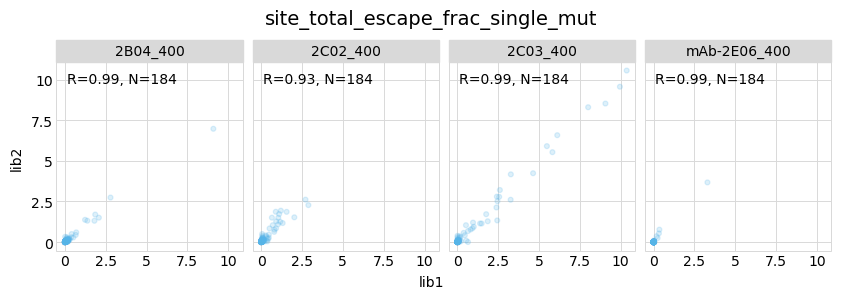

In [17]:
libraries = [lib for lib in effects_df['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for val, color in [
        ('site_avg_escape_frac_epistasis_model', CBPALETTE[1]),
        ('site_avg_escape_frac_single_mut', CBPALETTE[1]),
        ('site_total_escape_frac_epistasis_model', CBPALETTE[2]),
        ('site_total_escape_frac_single_mut', CBPALETTE[2]),
        ]:
    # wide data frame with each library's score in a different column
    site_effects_df_wide = (
        site_effects_df
        .query('library != "average"')
        # just get selections with 2 libraries
        .assign(nlibs=lambda x: x.groupby('selection')['library'].transform('nunique'))
        .query('nlibs == 2')
        # now make columns for each library, only keep sites with scores for both libs
        .pivot_table(index=['selection', 'site'],
                     columns='library',
                     values=val)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        site_effects_df_wide
        .groupby('selection')
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['selection', 'correlation']]
        # add number of mutations measured
        .merge(site_effects_df_wide
               .groupby('selection')
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    nfacets = site_effects_df_wide['selection'].nunique()
    ncol = min(nfacets, 5)
    nrow = math.ceil(nfacets / ncol)
    xmin = site_effects_df_wide[libraries[0]].min()
    xspan = site_effects_df_wide[libraries[0]].max() - xmin
    ymin = site_effects_df_wide[libraries[1]].min()
    yspan = site_effects_df_wide[libraries[1]].max() - ymin
    p = (ggplot(site_effects_df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(alpha=0.2, color=color) +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_wrap('~ selection', ncol=ncol) +
         theme(figure_size=(2.5 * ncol, 2.5 * nrow),
               plot_title=element_text(size=14)) +
         ggtitle(val)
         )

    _ = p.draw()

## Write file with escape fractions at mutation and site levels
We write a files that has the mutation- and site-level escape fractions.
This file has both the separate measurements for each library **plus** the average across libraries for all mutations measured in both libraries.
We name the columns in such a way that this file can be used as [dms-view data file](https://dms-view.github.io/docs/dataupload/):

In [18]:
escape_fracs_to_write = (
    effects_df
    .merge(site_effects_df,
           how='left',
           validate='many_to_one',
           on=['selection', 'library', 'site'])
    .assign(protein_chain=config['escape_frac_protein_chain'],
            protein_site=lambda x: x['site'] + config['escape_frac_protein_site_offset'],
            label_site=lambda x: x['protein_site'],
            condition=lambda x: x['selection'].where(x['library'] == "average", x['selection'] + '_' + x['library']),
            mutation=lambda x: x['mutant'],  # dms-view uses mutation to refer to mutant amino acid
            )
    [['selection', 'library', 'condition', 'site', 'label_site', 'wildtype', 'mutation',
      'protein_chain', 'protein_site', 'mut_escape_frac_epistasis_model', 'mut_escape_frac_single_mut',
      'site_total_escape_frac_epistasis_model', 'site_total_escape_frac_single_mut',
      'site_avg_escape_frac_epistasis_model', 'site_avg_escape_frac_single_mut', 'nlibs',
      ]]
    .sort_values(['library', 'selection', 'site', 'mutation'])
    )

print('Here are the first few lines that will be written to the escape-fraction file:')
display(HTML(escape_fracs_to_write.head().to_html(index=False)))

print(f"\nWriting to {config['escape_fracs']}")
escape_fracs_to_write.to_csv(config['escape_fracs'], index=False, float_format='%.4g')

Here are the first few lines that will be written to the escape-fraction file:


selection,library,condition,site,label_site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
2B04_400,average,2B04_400,1,331,N,A,E,331,0.001161,0.000602,0.05265,0.065128,0.002771,0.003428,2
2B04_400,average,2B04_400,1,331,N,C,E,331,0.001007,0.002096,0.05265,0.065128,0.002771,0.003428,2
2B04_400,average,2B04_400,1,331,N,D,E,331,0.001007,0.001018,0.05265,0.065128,0.002771,0.003428,2
2B04_400,average,2B04_400,1,331,N,E,E,331,0.001067,0.001079,0.05265,0.065128,0.002771,0.003428,2
2B04_400,average,2B04_400,1,331,N,F,E,331,0.003066,0.001223,0.05265,0.065128,0.002771,0.003428,2



Writing to results/escape_scores/escape_fracs.csv


## Analyze and write homolog escape fractions
Now examine the escape scores and fractions for the homologs.
Recall these homologs are not mutagenized, so there is just a single estimate for each homolog.

First, plot the distribution of escape scores for the homologs.
If we grouped by amino-acid sequence when calculating escape scores, these will just be point estimates.
If we grouped by barcode, these will be distributions:

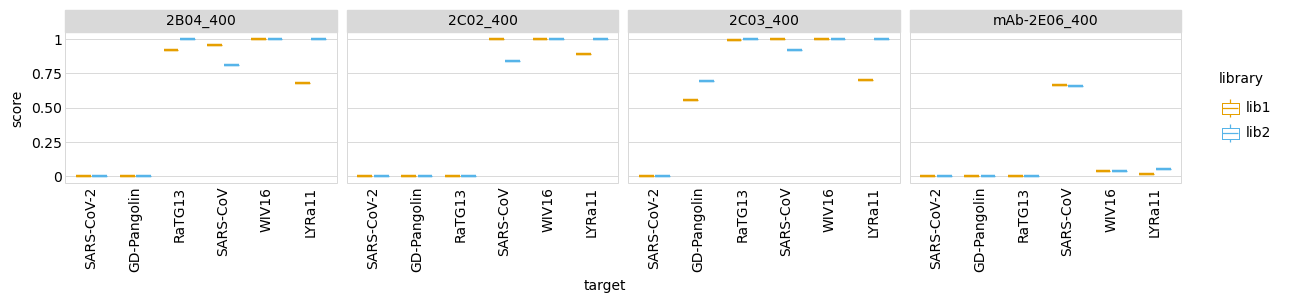

In [19]:
homolog_order = ['SARS-CoV-2','GD-Pangolin','RaTG13','SARS-CoV','WIV16','LYRa11']
escape_scores_homologs['target'] = pd.Categorical(escape_scores_homologs['target'], homolog_order, ordered=True)

nfacets = escape_scores_homologs['name'].nunique()
ncol = min(4, nfacets)
nrow = math.ceil(nfacets / ncol)
nhomologs = escape_scores_homologs['target'].nunique()

p = (ggplot(escape_scores_homologs) +
     aes('target', 'score', color='library') +
     geom_boxplot(outlier_size=1, outlier_alpha=0.2) +
     facet_wrap('~ name', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           panel_grid_major_x=element_blank(),
           figure_size=(0.6 * nhomologs * ncol, 2 * nrow),
           ) +
     scale_color_manual(values=CBPALETTE[1:])
     )

_ = p.draw()

We now compute our best estimate of the escape score for each homolog in each library.
If these were already grouped by amino-acid sequence, we already have these estimates.
Otherwise, if they were grouped by barcode we take the **median** of all of the variant-level measurements for each homolog.

We then convert the escape scores to escape fractions as above, and plot them:

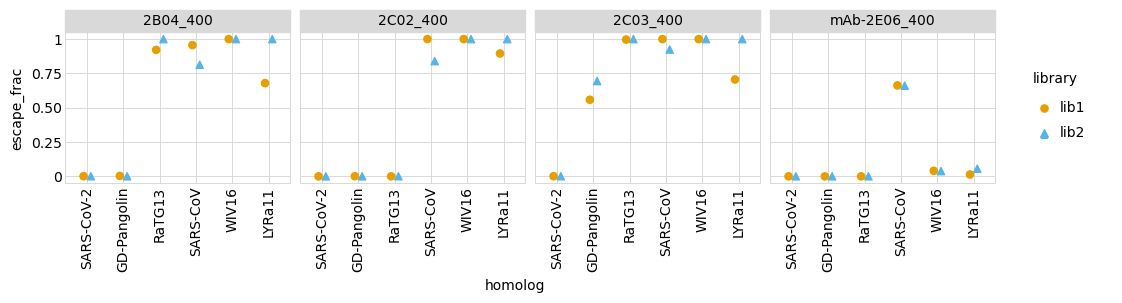

In [20]:
homolog_avgs = (
    escape_scores_homologs
    .rename(columns={'target': 'homolog',
                     'name': 'selection'})
    .groupby(['selection', 'homolog', 'library'])
    .aggregate(escape_score=pd.NamedAgg('score', 'median'))
    .assign(escape_frac=lambda x: x['escape_score'].map(score_to_frac))
    .reset_index()
    )

nfacets = homolog_avgs['selection'].nunique()
ncol = min(5, nfacets)
nrow = math.ceil(nfacets / ncol)
p = (ggplot(homolog_avgs) +
     aes('homolog', 'escape_frac', color='library', shape='library') +
     geom_point(size=2.5, position=position_dodge(width=0.4)) +
     facet_wrap('~ selection', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * homolog_avgs['homolog'].nunique() * ncol, 2 * nrow),
           ) +
     scale_color_manual(values=CBPALETTE[1:])
     )
_ = p.draw()

Now we write the homolog escape fractions to a file, first adding an "average" column for each homolog measured in both libraries:

In [21]:
nlibs = homolog_avgs['library'].nunique()
homolog_fracs = (
    homolog_avgs
    .assign(nlibs=1)
    .append(homolog_avgs
            .groupby(['selection', 'homolog'])
            .aggregate(nlibs=pd.NamedAgg('library', 'count'),
                       escape_frac=pd.NamedAgg('escape_frac', 'mean')
                       )
            .assign(library='average')
            .reset_index()
            )
    .sort_values(['library', 'selection', 'homolog'])
    [['selection', 'homolog', 'library', 'escape_frac', 'nlibs']]
    )

print('Here are the first few lines of the the homolog escape fraction:')
display(HTML(
    homolog_fracs
    .head()
    .to_html(index=False)
    ))

print(f"\nWriting the homolog escape fractons to {config['escape_fracs_homologs']}")
homolog_fracs.to_csv(config['escape_fracs_homologs'], index=False, float_format='%.4g')

Here are the first few lines of the the homolog escape fraction:


selection,homolog,library,escape_frac,nlibs
2B04_400,SARS-CoV-2,average,0.001487,2
2B04_400,GD-Pangolin,average,0.002225,2
2B04_400,RaTG13,average,0.960800,2
2B04_400,SARS-CoV,average,0.884700,2
2B04_400,WIV16,average,1.000000,2



Writing the homolog escape fractons to results/escape_scores/escape_fracs_homologs.csv
